In [39]:
import glob
import os, sys
import inspect
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 

import torch
import torch.nn as nn
import pandas
import numpy as np
import numpy.ma as ma
import pickle
import time

import proplot as pplt
import seaborn as sns
import sklearn
import re 
from fractions import Fraction
import scipy.stats as st

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
from utils import *
from plotting_functions import *

In [40]:
label_size = 12
pplt.rc['tick.labelsize'] = label_size 
pplt.rc['axes.labelsize'] = label_size + 3
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})

In [41]:
#load model
# 3892: Nrec100
# 8288: Nrec30
exp_list = glob.glob(currentdir+"\\experiments\\poisson_clicks\\perfect_model\\exp*6701") #01 #51, list experiment folders
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))
exp_path = exp_list[0]
idx = exp_path[-10:]
exp_list

['C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\perfect_model\\exp_1667316701']

In [43]:
with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)

training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

training_kwargs['device'] = device

rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
# rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu', constrain_spectrum=training_kwargs['constrain_spectrum']).to(device)
rnn_model = load_model(rnn_model, training_kwargs).to(device)

C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\perfect_model\exp_1667316701\weights1667316701.pth


In [44]:
weights_dict = {key: pandas.DataFrame(rnn_model.state_dict()[key].cpu()) for key in rnn_model.state_dict().keys()}
#input weights
W_ih = weights_dict['rnn.weight_ih_l0'] 
W_ih

,0,1,2,3
0,1.000187e+00,-2.418598e-04,-100.0,-0.000139
1,-3.626801e-04,1.000269e+00,-100.0,0.000002
2,-1.720708e-15,-2.760068e-15,-100.0,0.999782
3,-4.383844e-04,-4.150413e-04,-100.0,1.000020


In [45]:
##THE NORMAL
N_test_batch = 10**3
training_kwargs['fixed_cue_onsetandduration'] = [20,1,20,1]
training_kwargs['sum_of_rates'] = 40
training_kwargs['target_withcue'] = False
training_kwargs['equal_clicks'] = False
training_kwargs['T'] = 2000
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)

normal_x, normal_y, normal_output_mask, normal_trial_params = pd.get_trial_batch() #generate self.N_batch trials

ratio_array = np.array([normal_trial_params[i]['ratio'] for i in range(normal_trial_params.size)])
ratios = np.unique(ratio_array)

In [46]:
yhat, hidden_states = run_model_chunked(normal_x, rnn_model, hidden_initial_variance=0.0001, n_chunks=100)

In [47]:
yhat = yhat.cpu().detach().numpy()
# hidden_states = hidden_states.cpu().detach().numpy()
accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(normal_x, yhat, normal_output_mask)
print("Acc:", accuracy)

accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(normal_x, yhat, normal_output_mask, normal_trial_params)

Acc: 1.0


C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\scipy\stats\_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\scipy\stats\_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


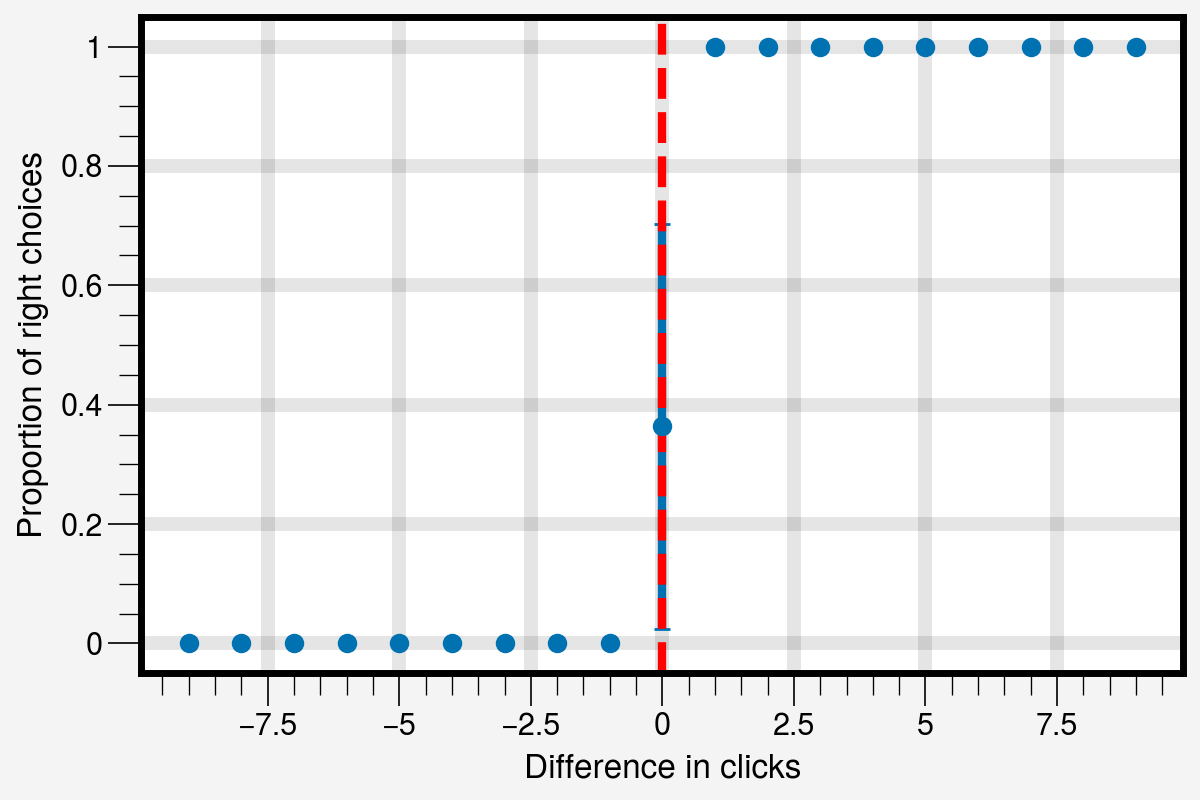

In [48]:
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})
pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
chosen = 1-np.argmax(np.mean(yhat*normal_output_mask, axis=1), axis = 1)
df = pandas.DataFrame({"Choice": chosen, "Difference": N_clicks[:,0]-N_clicks[:,1]})
df = df[abs(df['Difference']) < 10]
ci = np.array([st.t.interval(0.95, len(df['Choice'][df["Difference"] == i])-1, loc=np.mean(df['Choice'][df["Difference"] == i]), scale=st.sem(df['Choice'][df["Difference"] == i])) for i in np.sort(df['Difference'].unique())])
average_perclick = df.groupby("Difference").mean()
std_perclick = df.groupby("Difference").std().to_numpy().squeeze()
# ax.plot(np.sort(df['Difference'].unique()), average_perclick['Choice'].to_numpy(), 'x-')
ax.errorbar(np.sort(df['Difference'].unique()), average_perclick['Choice'].to_numpy(), yerr=np.abs(ci.T-average_perclick.to_numpy().T),
            fmt='.')
ax.axvline(x = 0, color = 'r', linestyle = '--')

ax.set_xlabel("Difference in clicks")
ax.set_ylabel("Proportion of right choices")
plt.savefig(training_kwargs['figures_path'] + "/psycho_curve.pdf")
plt.savefig(training_kwargs['figures_path'] + "/psycho_curve.png")

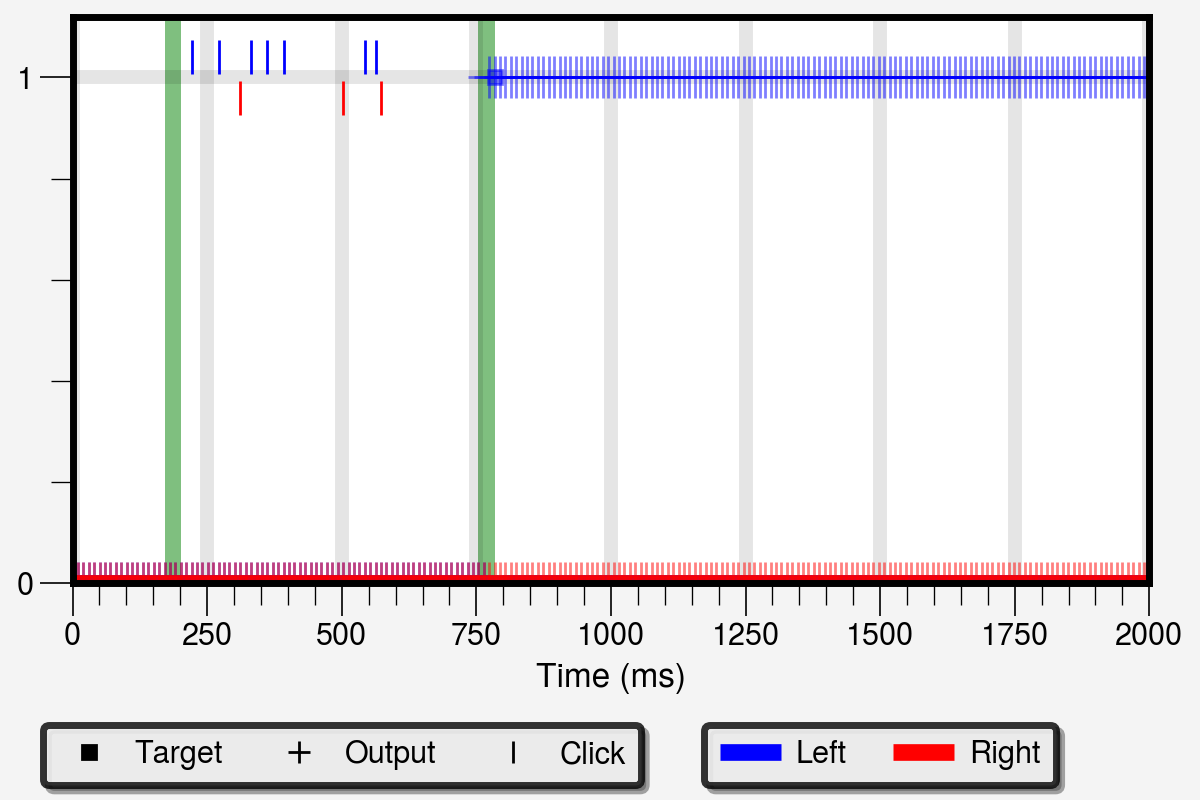

In [49]:
trial_i = 0

plot_trial(trial_i, x=normal_x, y=normal_y, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="correct_trial_example",
          maxT="full");

In [50]:
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(normal_x, yhat, normal_output_mask, normal_trial_params)
wrong_trials = get_wrong_trials(N_clicks, chosen)
trial_i = wrong_trials[0]
print("Click difference:", N_clicks[trial_i,0]-N_clicks[trial_i,1])
plot_trial(trial_i, x=normal_x, y=normal_y, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="wrong_trial_example",
           eps = 0.04, padding = 5,
          maxT="part");

IndexError: list index out of range

In [56]:
# #THE LONG RUN
N_test_batch = 10**4
training_kwargs['zero_target'] = 0.
training_kwargs['fixed_stim_duration_list'] = [100]
training_kwargs['fixed_cue_onsetandduration'] = [20,1,1800,1]
training_kwargs['T'] = 20000
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
extra_x, extra_y, extra_output_mask, extra_trial_params = pd.get_trial_batch()

In [57]:
yhat, hidden_states = run_model_chunked(extra_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)
yhat = yhat.cpu().detach().numpy()

In [58]:
# #accuracy vs coherence, with direction
# inputs = torch.tensor(extra_x, dtype=torch.float)
# extra_all_responses = np.zeros((len(exp_list), extra_y.shape[0], extra_y.shape[1], extra_y.shape[2]))

# ratio_array = np.array([extra_trial_params[i]['ratio'] for i in range(extra_trial_params.size)])
# ratios = np.unique(ratio_array)

# pplt.figure(figsize=(6,4))
# ax = plt.subplot(111)
# cmap = cm = plt.get_cmap('blues')
# cnorm = matplotlib.colors.Normalize(vmin=np.min(accuracy)-1, vmax=np.max(accuracy))
# smap = matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cm)

# faulty_extra = 0
# for expi, exp_path in enumerate(exp_list[1:]):
#     with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
#         training_kwargs = pickle.load(handle)
        
#     training_kwargs['exp_path'] = exp_path
#     training_kwargs['training_weights_path'] = exp_path+'/training/'
#     training_kwargs['figures_path'] = exp_path + '//figures/'
        
#     # rnn_model = load_model(rnn_model, training_kwargs)
#     weight_list = glob.glob(training_kwargs['training_weights_path']+'\\*')

#     weight_list = sorted(weight_list, key = lambda x: int(x.split("epoch")[-1].split(".")[-2]))
#     weight_list = sorted(weight_list, key = lambda x: (1/float(x.split("coh")[-1].split("_")[-3]), int(x.split("epoch")[-1].split(".")[-2])))

#     weight_path = weight_list[-110]
#     rnn_model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
        
#     rnn_model.eval();
#     yhat, hidden = rnn_model(inputs)
#     yhat_np = yhat.detach().numpy()

#     accuracy, response_correctness, N_clicks, highest_click_count_index, excludeequals = get_accuracy_poissonclicks_w(extra_x, yhat_np, extra_output_mask)
#     extra_all_responses[expi, ...] = yhat_np
    
#     plt.plot(ratios - np.sign(ratios), average_accuracy_per_ratio, 'x-', c=smap.to_rgba(accuracy))
# ax.set_xlabel("Coherence")
# ax.set_ylabel("Proportion of correct choices")
# plt.savefig(current_dir + exp_extension + "/extra_correct.pdf")

# print(faulty_extra)

In [59]:
accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(extra_x, yhat, extra_output_mask)
print("Acc:", accuracy)
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(extra_x, yhat, extra_output_mask, extra_trial_params)
wrong_and_equal_trials = np.where(~response_correctness)[0]
equal_trials = np.where(N_clicks[:,0]==N_clicks[:,1])[0]
wrong_trials = []
for trial in wrong_and_equal_trials:
    if trial in equal_trials:
        continue
    wrong_trials.append(trial)

Acc: 0.9998996185504919


Click difference: -22.0


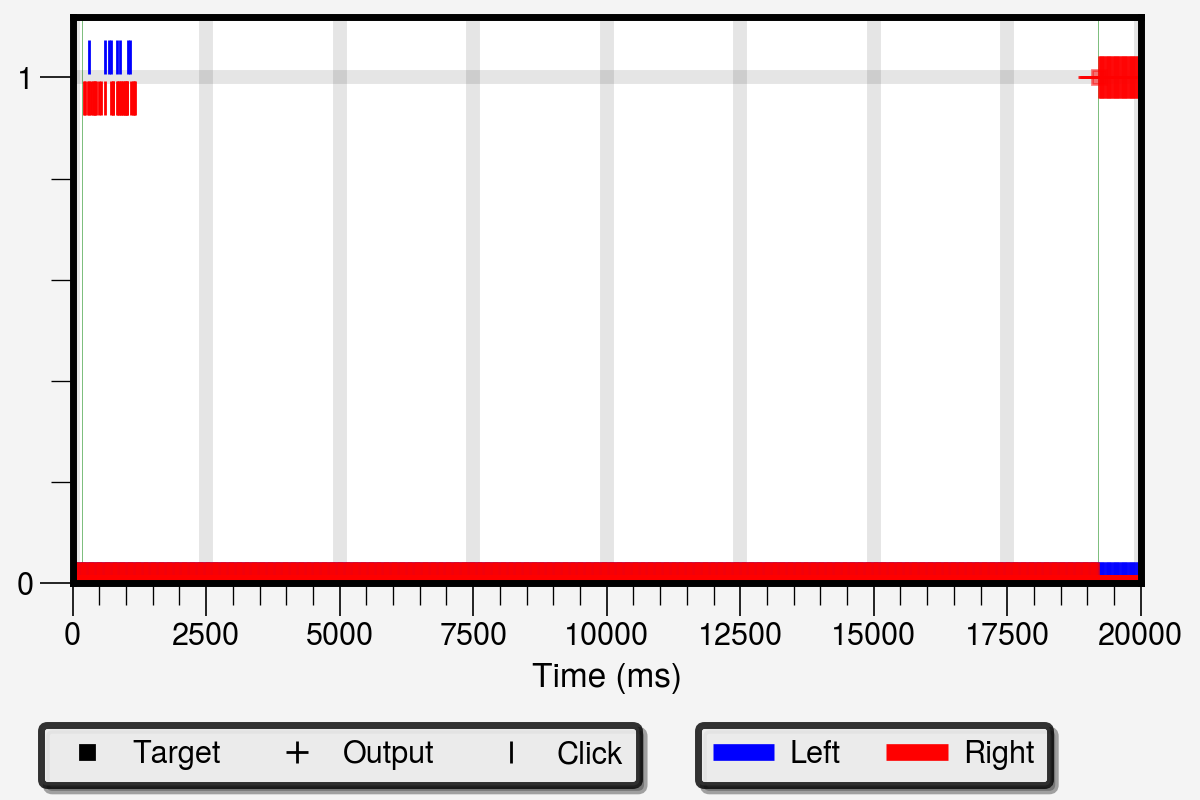

In [60]:
trial_i = 0
print("Click difference:", N_clicks[trial_i,0]-N_clicks[trial_i,1])
plot_trial(trial_i, x=extra_x, y=extra_y, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="extra_delay_trial",
           eps = 0.04, padding = 5,
          maxT="full");

Click difference: 1.0


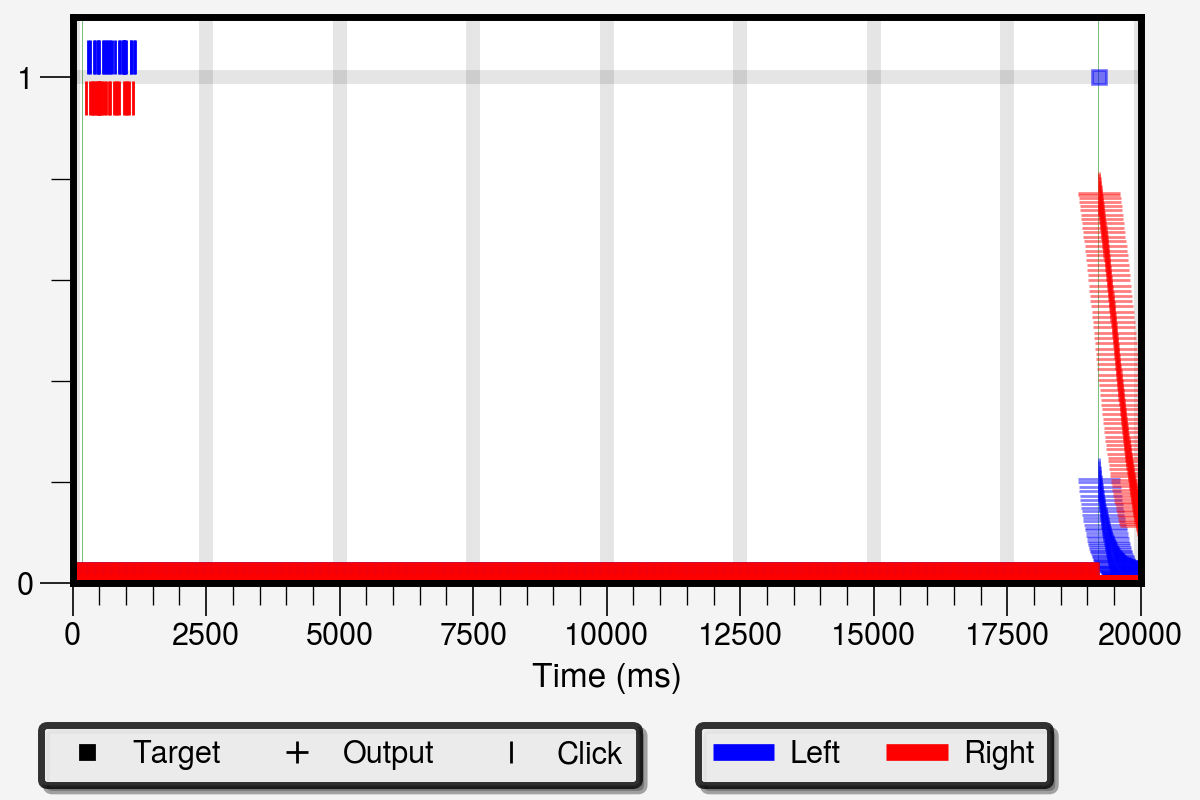

In [61]:
trial_i = wrong_trials[0]
print("Click difference:", N_clicks[trial_i,0]-N_clicks[trial_i,1])
plot_trial(trial_i, x=extra_x, y=extra_y, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="wrong_extra_delay_trial",
           eps = 0.04, padding = 5,
          maxT="full");

In [64]:
extra_pause_list = np.arange(0, 1010, 250, dtype=int)

cmap = cm = plt.get_cmap('blues')
cnorm = matplotlib.colors.Normalize(vmin=np.min(extra_pause_list)-500, vmax=np.max(extra_pause_list))
smap = matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cm)

for expi, exp_path in enumerate(exp_list[:1]):
    print(exp_path)
    with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
        training_kwargs = pickle.load(handle)
    pplt.figure(figsize=(6,4))
    ax = plt.subplot(111)
    training_kwargs['exp_path'] = exp_path
    training_kwargs['training_weights_path'] = exp_path+'/training/'
    training_kwargs['figures_path'] = exp_path + '//figures/'
    
    training_kwargs['fixed_stim_duration_list'] = [100]
    training_kwargs['T'] = 12000

    training_kwargs['device'] = 'cpu'
    rnn_model = load_model(rnn_model, training_kwargs);
    for extra_pause in extra_pause_list:
        training_kwargs['fixed_cue_onsetandduration']= [20, 1, 20+extra_pause, 1]

        pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)

        extra_x, extra_y, extra_output_mask, extra_trial_params = pd.get_trial_batch() #generate self.N_batch trials

        #accuracy vs coherence, with direction
        inputs = torch.tensor(extra_x, dtype=torch.float)
        extra_all_responses = np.zeros((len(exp_list), extra_y.shape[0], extra_y.shape[1], extra_y.shape[2]))

        yhat, hidden_states = run_model_chunked(extra_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)
        yhat = yhat.cpu().detach().numpy()

        extra_all_responses[expi, ...] = yhat
        accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(extra_x, yhat, extra_output_mask)
        print("Acc:", accuracy, "Extra:", extra_pause)

        chosen_without_equals = 1-np.argmax(np.mean(yhat*extra_output_mask, axis=1), axis = 1)[excludeequals]
        df = pandas.DataFrame({"Choice": chosen_without_equals, "Difference": N_clicks[excludeequals,0]-N_clicks[excludeequals,1]})
        average_perclick = df.groupby("Difference").mean()
        ax.plot(np.sort(df['Difference'].unique()), average_perclick['Choice'].to_numpy(), '-', c=smap.to_rgba(extra_pause), label=extra_pause*training_kwargs['dt'])

    ax.set_xlabel("Difference in clicks")
    ax.set_ylabel("Proportion of right choices")
    ax.legend(title="Extra delay", loc='upper center', bbox_to_anchor=(0.5, -0.22),
          fancybox=True, shadow=True, ncol=5)
    plt.savefig(training_kwargs['figures_path'] + "/extra_prop_decrease.pdf")
    plt.savefig(training_kwargs['figures_path'] + "/extra_prop_decrease.png")
    plt.close()

C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\perfect_model\exp_1667316701
C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\perfect_model\exp_1667316701\weights1667316701.pth
Acc: 1.0 Extra: 0
Acc: 1.0 Extra: 250
Acc: 1.0 Extra: 500
Acc: 1.0 Extra: 750
Acc: 1.0 Extra: 1000


### Two pulses

In [31]:
training_kwargs['zero_target'] = 0.
training_kwargs['fixed_stim_duration_list'] = [20, 1800, 20]
training_kwargs['fixed_cue_onsetandduration']= [20, 1, 20, 1]
training_kwargs['T'] = 20000

In [32]:
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
extra_x, extra_y, extra_output_mask, extra_trial_params = pd.get_trial_batch() #generate self.N_batch trials

yhat, hidden_states = run_model_chunked(extra_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)
yhat = yhat.cpu().detach().numpy()

In [33]:
accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(extra_x, yhat, extra_output_mask)
print("Acc:", accuracy)

Acc: 0.9744376278118609


Click difference: 9.0


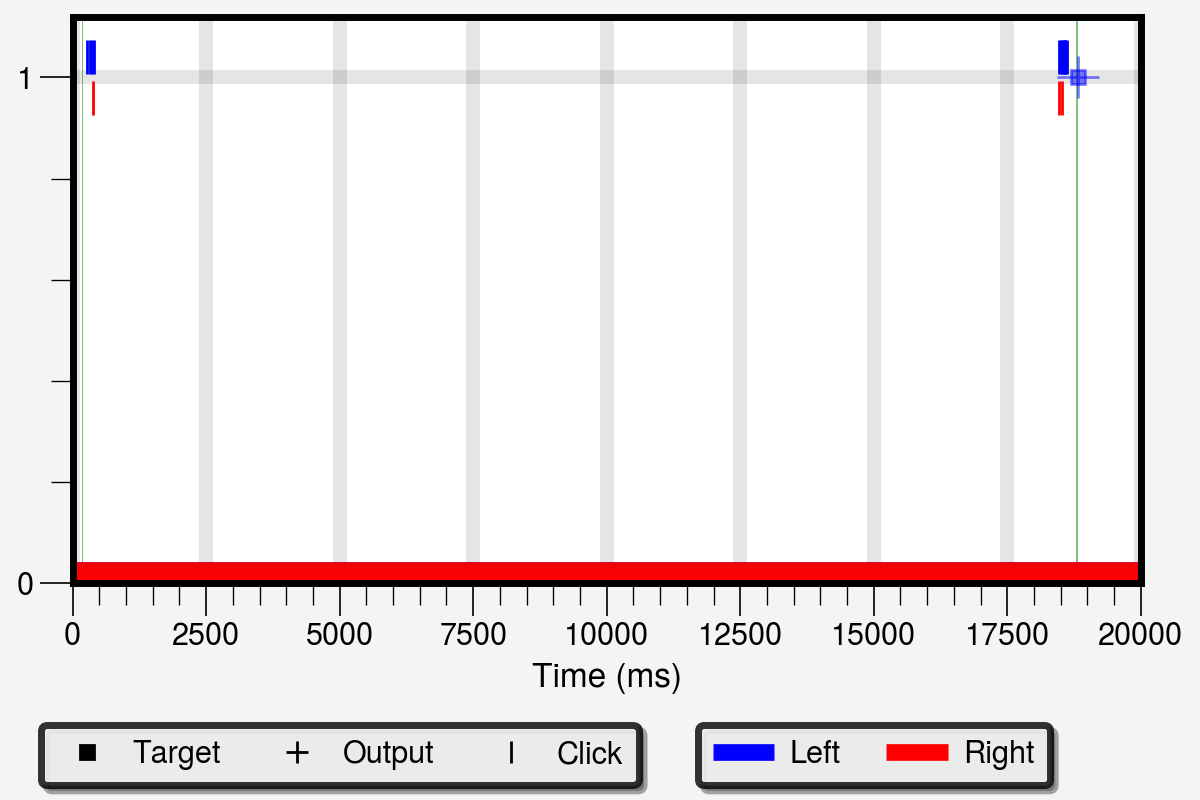

In [34]:
trial_i = 20
print("Click difference:", N_clicks[trial_i,0]-N_clicks[trial_i,1])
plot_trial(trial_i, x=extra_x, y=extra_y, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="two_pulse_trial",
           eps = 0.04, padding = 5,
          maxT="full");

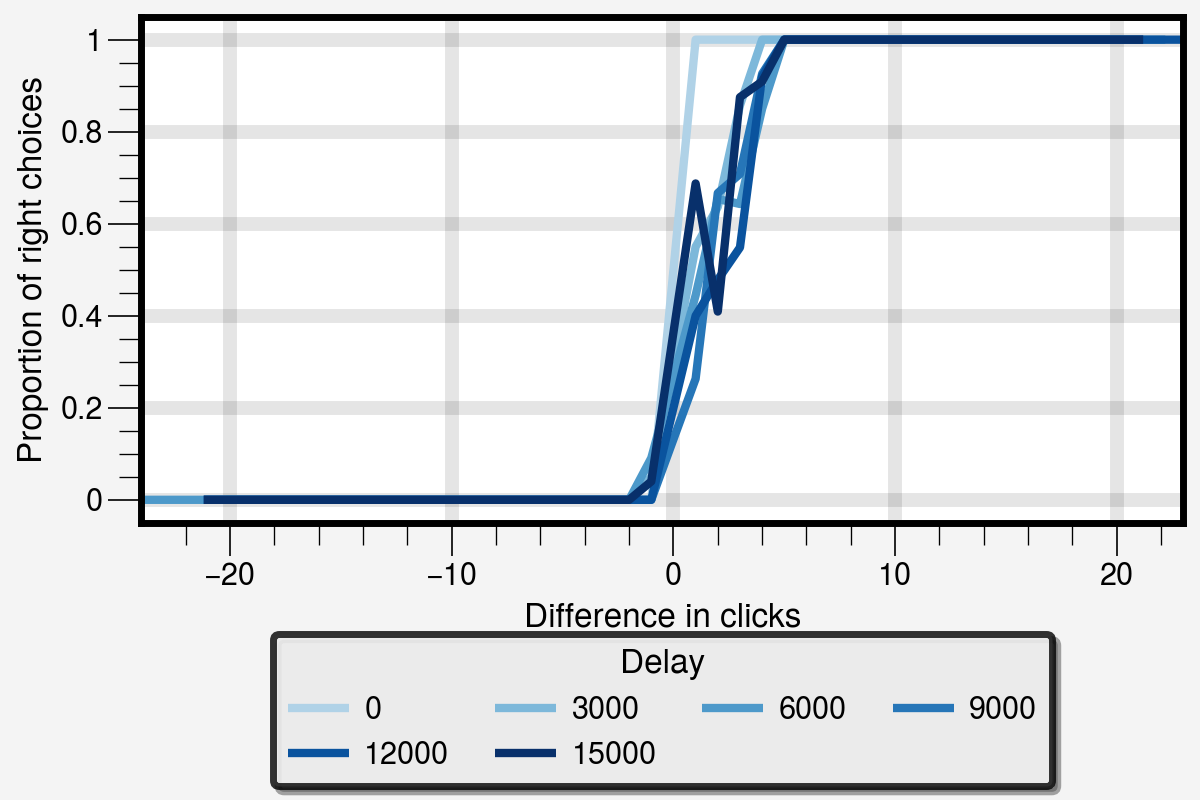

In [35]:
pplt.figure(figsize=(6,4))
ax = plt.subplot(111)

pause_list = np.arange(0, 1800, 300)

cmap = cm = plt.get_cmap('blues')
cnorm = matplotlib.colors.Normalize(vmin=np.min(pause_list)-700, vmax=np.max(pause_list))
smap = matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cm)

all_x = np.zeros((pause_list.shape[0], N_test_batch, int(training_kwargs['T']/training_kwargs['dt']), 4))
all_yhat = np.zeros((pause_list.shape[0], N_test_batch, int(training_kwargs['T']/training_kwargs['dt']), 2))

for pause_i, pause in enumerate(pause_list):
    training_kwargs['fixed_stim_duration_list'] = [20, pause, 20]

    pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
    extra_x, extra_y, extra_output_mask, extra_trial_params = pd.get_trial_batch() #generate self.N_batch trials

    yhat, hidden_states = run_model_chunked(extra_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)
    yhat = yhat.cpu().detach().numpy()
    
    all_x[pause_i,...] = extra_x
    all_yhat[pause_i,...] = yhat

    accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(extra_x, yhat, extra_output_mask)
    chosen_without_equals = 1-np.argmax(np.mean(yhat*extra_output_mask, axis=1), axis = 1)[excludeequals]
    df = pandas.DataFrame({"Choice": chosen_without_equals, "Difference": N_clicks[excludeequals,0]-N_clicks[excludeequals,1]})
    average_perclick = df.groupby("Difference").mean()
    ax.plot(np.sort(df['Difference'].unique()), average_perclick['Choice'].to_numpy(), '-', c=smap.to_rgba(pause), label=pause*training_kwargs['dt'])

    ax.set_xlabel("Difference in clicks")
    ax.set_ylabel("Proportion of right choices")
ax.legend(title="Delay", loc='upper center', bbox_to_anchor=(0.5, -0.22),
          fancybox=True, shadow=True, ncol=4)
plt.savefig(training_kwargs['figures_path'] + "/twopulse_props.pdf")
plt.savefig(training_kwargs['figures_path'] + "/twopulse_props.png")

Click difference: -6.0


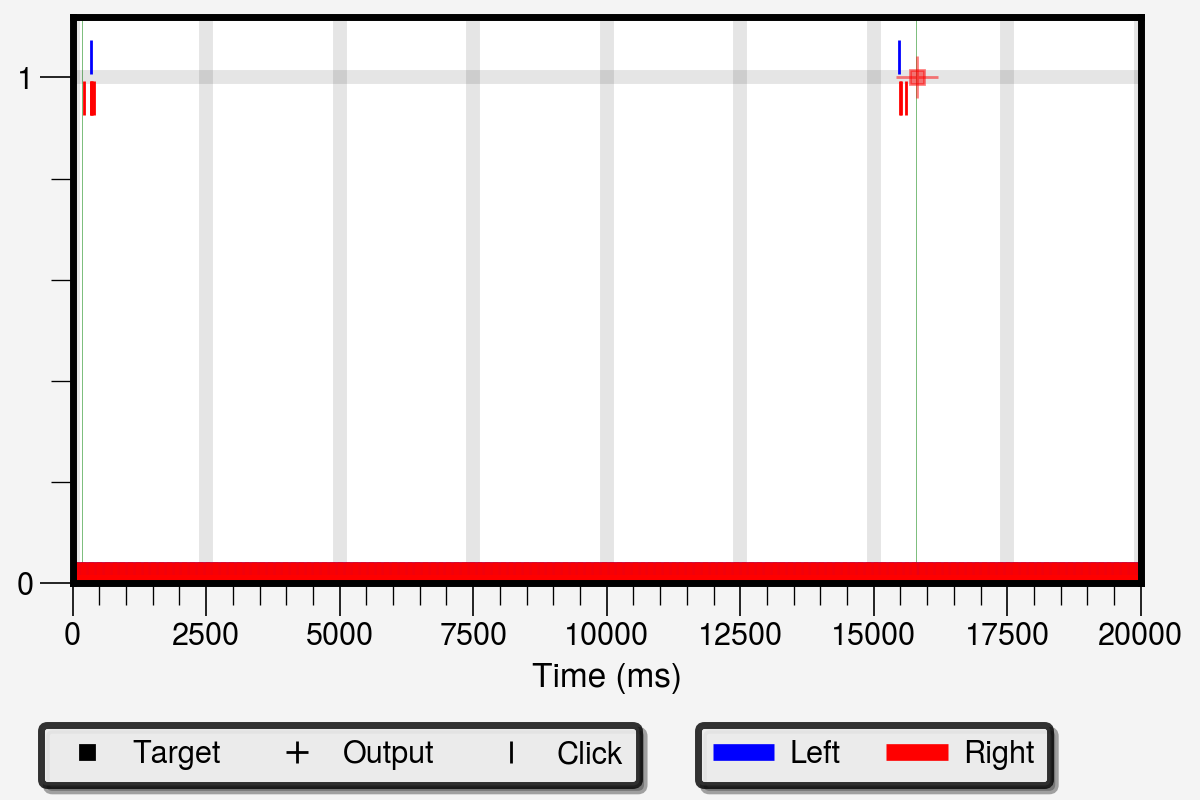

In [36]:
pause_i = -1
inputs = all_x[pause_i,...]
extra_y = all_yhat[pause_i,...]

trial_i = 222
print("Click difference:", N_clicks[trial_i,0]-N_clicks[trial_i,1])
plot_trial(trial_i, x=extra_x, y=extra_y, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="twopulse_trial%d.pdf"%pause_list[pause_i],
           eps = 0.04, padding = 5,
          maxT="full");

### Two different pulses

In [65]:
N_test_batch = 10**4
training_kwargs['coherence_list'] = [1.]
training_kwargs['fixed_cue_onsetandduration']= [10, 1, 20, 1]
training_kwargs['T'] = 2000
training_kwargs['fixed_stim_duration_list'] = [20]
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
x1, _, _, _ = pd.get_trial_batch() 

training_kwargs['fixed_cue_onsetandduration']= [10+90, 1, 20, 1]
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
x2, extra_y1, extra_output_mask, extra_trial_params = pd.get_trial_batch() 

extra_x = np.zeros((N_test_batch,int(training_kwargs['T']/training_kwargs['dt']),4))
extra_x[...,:2] = x1[...,:2] + x2[...,:2]
extra_x[:,:15,2] = x1[:,:15,2]
extra_x[:,120:,3] = x2[:,120:,3]

yhat, hidden_states = run_model_chunked(extra_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)
yhat = yhat.cpu().detach().numpy()

Click difference: -18.0


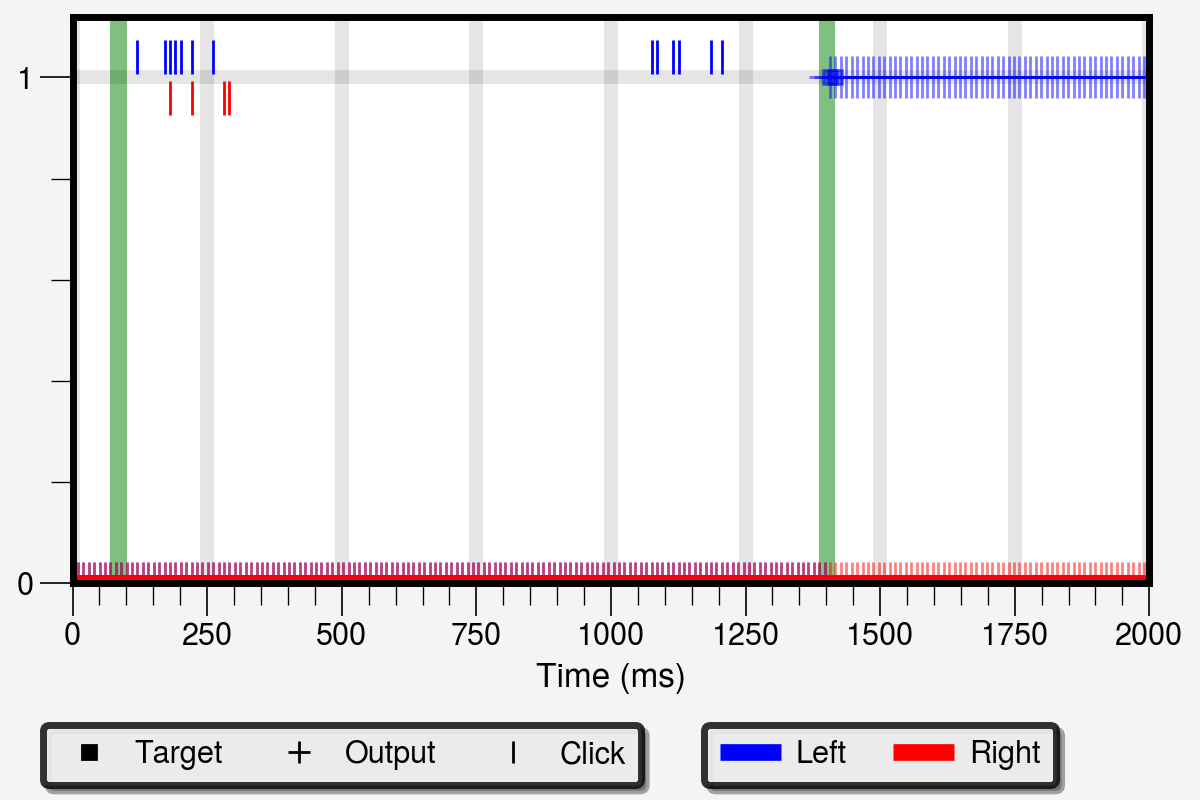

In [66]:
trial_i = 99
print("Click difference:", N_clicks[trial_i,0]-N_clicks[trial_i,1])
plot_trial(trial_i, x=extra_x, y=extra_y1, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="twopulse_different_trial",
           eps = 0.04, padding = 5,
          maxT="full");

In [67]:
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(extra_x, yhat, extra_output_mask, extra_trial_params)
error_idx = np.where(response_correctness==False)[0]
accuracy

1.0

ValueError: zero-size array to reduction operation minimum which has no identity

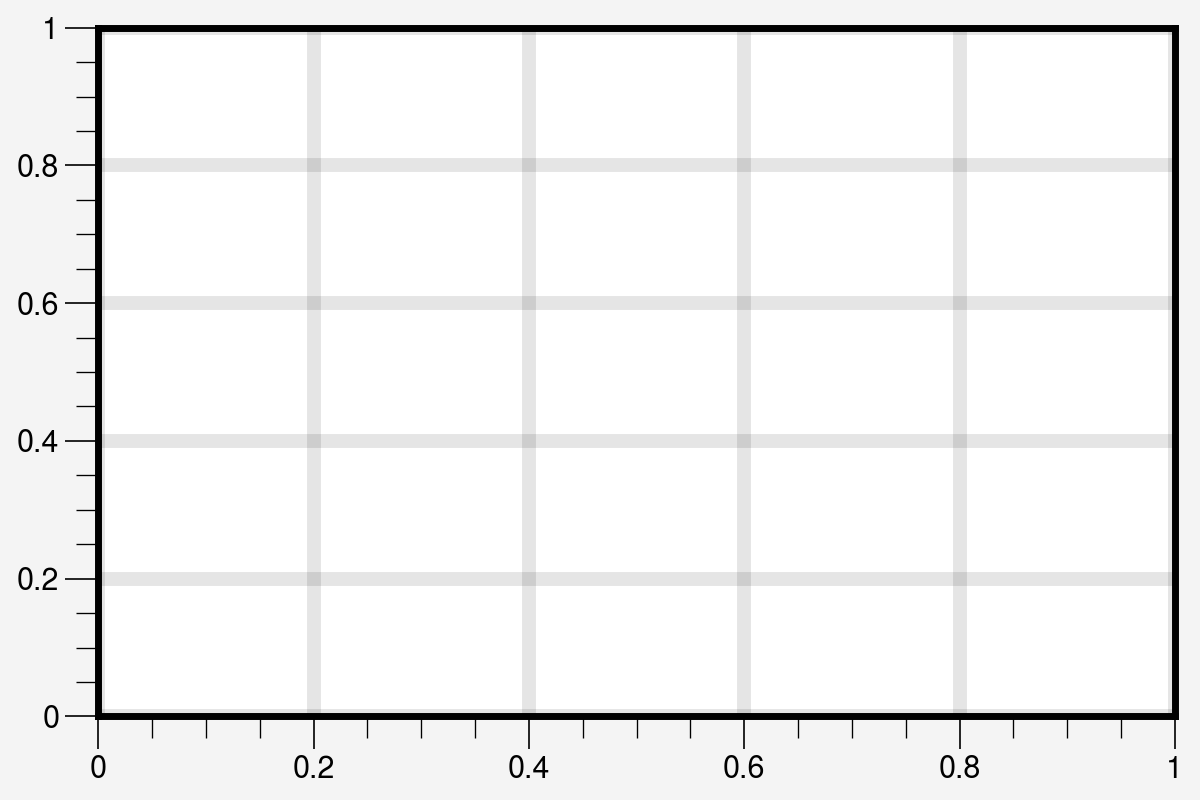

In [68]:
pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
click_diffs = N_clicks[error_idx][:,0]-N_clicks[error_idx][:,1]
bins=np.arange(int(np.min(click_diffs)),int(np.max(click_diffs)))
plt.hist(click_diffs, bins=bins,  weights=np.ones(len(click_diffs)) / N_test_batch)
ax.set_xlabel("Click difference")
ax.set_ylabel("Proportion of erroneous choices")
ax.set_xticks(bins+.5)
ax.set_xticklabels(bins)
ax.tick_params(axis='x', which='minor', bottom=False)
plt.savefig(training_kwargs['figures_path'] + "\\errors_per_clickdifference_twodiffpulses.pdf")
plt.savefig(training_kwargs['figures_path'] + "\\errors_per_clickdifference_twodiffpulses.png")

In [ ]:
# training_kwargs['zero_target'] = 0.
# training_kwargs['fixed_cue_onsetandduration']= [10, 1, 20, 1]
# training_kwargs['fixed_stim_duration_list'] = [20]
# training_kwargs['T'] = 1100

# pplt.figure(figsize=(6,4))
# ax = plt.subplot(111)

# pause_list = np.arange(0, 32, 8)

# cmap = cm = plt.get_cmap('blues')
# cnorm = matplotlib.colors.Normalize(vmin=np.min(pause_list)-.5*np.max(pause_list), vmax=np.max(pause_list))
# smap = matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cm)

# all_x = np.zeros((pause_list.shape[0], N_test_batch, int(training_kwargs['T']/training_kwargs['dt']), 4))
# all_yhat = np.zeros((pause_list.shape[0], N_test_batch, int(training_kwargs['T']/training_kwargs['dt']), 2))

# for pause_i, pause in enumerate(pause_list):
#     training_kwargs['fixed_cue_onsetandduration']= [10, 1, 20, 1]
#     pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
#     x1, _, _, _ = pd.get_trial_batch() 

#     training_kwargs['fixed_cue_onsetandduration']= [10+pause, 1, 20, 1]
#     pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
#     x2, _, extra_output_mask, extra_trial_params = pd.get_trial_batch() 

#     extra_x = np.zeros((N_test_batch,int(training_kwargs['T']/training_kwargs['dt']),4))
#     extra_x[...,:2] = x1[...,:2] + x2[...,:2]
#     extra_x[...,2] = x1[...,2]
#     extra_x[...,3] = x2[...,3]
    
#     yhat, hidden_states = run_model_chunked(extra_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)
#     yhat = yhat.cpu().detach().numpy()
    
#     all_x[pause_i,...] = extra_x
#     all_yhat[pause_i,...] = yhat

#     accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(extra_x, yhat, extra_output_mask)
        
#     chosen_without_equals = 1-np.argmax(np.mean(yhat*extra_output_mask, axis=1), axis = 1)[excludeequals]
#     df = pandas.DataFrame({"Choice": chosen_without_equals, "Difference": N_clicks[excludeequals,0]-N_clicks[excludeequals,1]})
#     average_perclick = df.groupby("Difference").mean()
#     ax.plot(np.sort(df['Difference'].unique()), average_perclick['Choice'].to_numpy(), 'x-', c=smap.to_rgba(pause), label=pause*training_kwargs['dt'])

#     ax.set_xlabel("Difference in clicks")
#     ax.set_ylabel("Proportion of right choices")
# ax.legend(title="Extra delay", loc='upper center', bbox_to_anchor=(0.5, -0.22),
#           fancybox=True, shadow=True, ncol=4)
# plt.savefig(training_kwargs['figures_path'] + "/twopulse_props_max%d.pdf"%training_kwargs['T'])
# plt.savefig(training_kwargs['figures_path'] + "/twopulse_props_max%d.png"%training_kwargs['T'])

In [ ]:
delay = 300
training_kwargs['zero_target'] = 0.
training_kwargs['fixed_cue_onsetandduration']= [10, 1, delay, 1]
training_kwargs['fixed_stim_duration_list'] = [20]
training_kwargs['T'] = 13000
# training_kwargs['sum_of_rates'] = 40

pplt.figure(figsize=(6,4))
ax = plt.subplot(111)

pause_list = np.arange(0, 901, 300)

cmap = cm = plt.get_cmap('blues')
cnorm = matplotlib.colors.Normalize(vmin=np.min(pause_list)-.5*np.max(pause_list), vmax=np.max(pause_list))
smap = matplotlib.cm.ScalarMappable(norm=cnorm, cmap=cm)

all_x = np.zeros((pause_list.shape[0], N_test_batch, int(training_kwargs['T']/training_kwargs['dt']), 4))
all_yhat = np.zeros((pause_list.shape[0], N_test_batch, int(training_kwargs['T']/training_kwargs['dt']), 2))

for pause_i, pause in enumerate(pause_list):
    training_kwargs['sum_of_rates'] = 20
    training_kwargs['fixed_cue_onsetandduration']= [10, 1, delay, 1]
    pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
    x1, _, _, _ = pd.get_trial_batch() 

    training_kwargs['sum_of_rates'] = 10
    training_kwargs['fixed_cue_onsetandduration']= [10+pause, 1, delay, 1]
    pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
    x2, _, extra_output_mask, extra_trial_params = pd.get_trial_batch() 

    extra_x = np.zeros((N_test_batch,int(training_kwargs['T']/training_kwargs['dt']),4))
    extra_x[...,:2] = x1[...,:2] + x2[...,:2]
    extra_x[:,:15,2] = x1[:,:15,2]
    extra_x[:,120:,3] = x2[:,120:,3]
    
    yhat, hidden_states = run_model_chunked(extra_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)
    yhat = yhat.cpu().detach().numpy()
    
    all_x[pause_i,...] = extra_x
    all_yhat[pause_i,...] = yhat

    accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(extra_x, yhat, extra_output_mask)
        
    chosen_without_equals = 1-np.argmax(np.mean(yhat*extra_output_mask, axis=1), axis = 1)[excludeequals]
    df = pandas.DataFrame({"Choice": chosen_without_equals, "Difference": N_clicks[excludeequals,0]-N_clicks[excludeequals,1]})
    average_perclick = df.groupby("Difference").mean()
    ax.plot(np.sort(df['Difference'].unique()), average_perclick['Choice'].to_numpy(), '-', c=smap.to_rgba(pause), label=pause*training_kwargs['dt'])
    ax.set_xlabel("Difference in clicks")
    ax.set_ylabel("Proportion of right choices")
ax.legend(title="Delay", loc='upper center', bbox_to_anchor=(0.5, -0.35),
          fancybox=True, shadow=True, ncol=4)
plt.savefig(training_kwargs['figures_path'] + "/twopulse_props_max%d.pdf"%training_kwargs['T'])
plt.savefig(training_kwargs['figures_path'] + "/twopulse_props_max%d.png"%training_kwargs['T'])

In [ ]:
import matplotlib.colors as mplcolors

x=extra_x
output_mask=extra_output_mask
trial_params=extra_trial_params
sns.set_context("poster", font_scale = .7, rc={"grid.linewidth": 5})
fig=plt.figure(figsize=(6,6))
ax = plt.subplot(111)
clickdiff = N_clicks[:,0]-N_clicks[:,1]
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)
direction = np.where(N_clicks[:,0]<N_clicks[:,1],-1,np.where(N_clicks[:,0]>N_clicks[:,1],1,0))

norm = mplcolors.CenteredNorm()
# norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
rand_normal_y_norm = norm(clickdiff)
cmap = cmx.get_cmap("coolwarm")

colors_list = ['b', 'r']
for trial_i in range(100):
    hs = ax.plot(np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0]), hidden_states[trial_i, :, 0], c=cmap(rand_normal_y_norm[trial_i]))
    
    
hs = ax.scatter(0, 0, c=0, s=.0, cmap=cmap, vmin=min(clickdiff), vmax=max(clickdiff))
plt.colorbar(hs, ax=ax, label='Click difference')
plt.xlabel("Time")
plt.ylabel("Activity")
plt.savefig(training_kwargs['figures_path'] + '\\hidden_activity_100_twopulse.pdf')
plt.savefig(training_kwargs['figures_path'] + '\\hidden_activity_100_twopulse.png')

### Two right clicks, then later one Left

In [ ]:
delay = 6

extra_x = np.zeros((1000, 200, 4))
extra_output_mask = np.zeros((1000, 200, 2))
extra_x[:,6:8,0] = 1.
extra_x[:,8+delay,1] = 1.

extra_x[:,4:5,2] = 1.
extra_x[:,8+10+delay:8+10+delay+1,3] = 1.

extra_output_mask[:,8+10+delay+1:8+10+delay+20+1,:] = 1.

yhat, hidden_states = run_model_chunked(extra_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)
yhat = yhat.cpu().detach().numpy()

In [ ]:
N_clicks = np.sum(extra_x, axis=1)
highest_click_count_index = np.argmax(N_clicks[:,:2], axis=1)
truth = highest_click_count_index
chosen = np.argmax(np.mean(yhat*extra_output_mask, axis=1), axis = 1)
response_correctness = np.equal(truth, chosen)
accuracy = np.mean(response_correctness)
error_idx = np.where(response_correctness==False)[0]
error_idx.shape

In [ ]:
trial_i = 14
plot_trial(0, x=extra_x, y=0*extra_x, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="twooneclick_trial",
           eps = 0.04, padding = 5,
          maxT="full");

In [ ]:
#two Right clicks, then (much) later one Left
accuracies = []
delay_list = np.linspace(0,251, 100, dtype=int)
for delay in delay_list:

    extra_x = np.zeros((1000, 500, 4))
    extra_output_mask = np.zeros((1000, 500, 2))

    extra_x[:,6:8,0] = 1.
    extra_x[:,8+delay,1] = 1.

    extra_x[:,4:5,2] = 1.
    extra_x[:,8+10+delay:8+10+delay+1,3] = 1.

    extra_output_mask[:,8+10+delay+1:8+10+delay+20+1,:] = 1.

    yhat, hidden_states = run_model_chunked(extra_x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)
    yhat = yhat.cpu().detach().numpy()
    
    N_clicks = np.sum(extra_x[:,:,:2], axis=1)
    highest_click_count_index = np.argmax(N_clicks[:,:2], axis=1)
    truth = highest_click_count_index
    chosen = np.argmax(np.mean(yhat_np*extra_output_mask, axis=1), axis = 1)
    response_correctness = np.equal(truth, chosen)
    accuracy = np.mean(response_correctness)
    error_idx = np.where(response_correctness==False)[0]
    
    accuracies.append(accuracy)

In [ ]:
fig = pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot(delay_list*training_kwargs['dt'], accuracies)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Proportion correct");

In [ ]:
#ROC
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(test_x, yhat_np, output_mask, trial_params)

truth = highest_click_count_index[excludeequals]
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(truth, chosen)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--");